In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel as ndde
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
from src.advec_diff_case.AD_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy as spy
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from shutil import move
import pickle

print(tf.__version__)

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.6.0-dev20210501


## Define some useful classes

### Class for user-defined arguments

In [4]:
class res_ad_eq_nDDE_args(ndde.arguments, adeq.ad_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, state_dim = 2, adj_data_size = 2,
                 model_dir = 'ROM_nODE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, L = 1., nx_high_res = 100, nx_low_res = 25, Re = 250, u_bc_0 = 0., u_bc_L =0., isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1): # add more arguments as needed
        
        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = nx_low_res, adj_data_size = nx_low_res, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)

        adeq.ad_eqn_args.__init__(self, T = T, nt = nt, L = L, nx = nx_low_res, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L,
                              multi_solve_size = batch_size)
        
        self.args_for_high_res = adeq.ad_eqn_args(T = T, nt = nt, L = L, nx = nx_high_res, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, 
                              multi_solve_size = 1)
        
        self.args_for_low_res = adeq.ad_eqn_args(T = T, nt = nt, L = L, nx = nx_low_res, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, 
                              multi_solve_size = 1)
        
        self.nx_high_res = nx_high_res
        self.nx_low_res = nx_low_res
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

### Define the NN architecture

In [5]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, args, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)

        self.c1 = tf.keras.layers.Conv1D(filters=4, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c2 = tf.keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c3 = tf.keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c4 = tf.keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.c5 = tf.keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.dc1 = tf.keras.layers.Conv1DTranspose(filters=3, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.dc2 = tf.keras.layers.Conv1DTranspose(filters=2, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.dc3 = tf.keras.layers.Conv1DTranspose(filters=2, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.dc4 = tf.keras.layers.Conv1DTranspose(filters=2, kernel_size=3, strides=1, activation='swish',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.dc_out = tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=3, strides=1, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.flat = tf.keras.layers.Flatten()
        
        self.args = args


    @tf.function
    def pass_layers(self, y_nn):
        
        for i in range(len(self.layers)):
            y_nn = self.layers[i](y_nn)
            
        return y_nn
    
    def call(self, y_nn):
        
        y_nn = self.pass_layers(y_nn)
        
        return y_nn

In [6]:
class DiscDDEFunc(tf.keras.Model):

    def __init__(self, main, rom_model, args, **kwargs):
        super(DiscDDEFunc, self).__init__(**kwargs)
        
        self.main = main
        self.rom_model = rom_model
        self.args = args
        
    def process_input(self, y, t ,d):     
        
        input = tf.expand_dims(y(t), axis=-1)
        
        return input

    def call_nn_part(self, input):
        dy_dt = self.main(input)
        return dy_dt
    
    def __call__(self, y, t ,d, t_start = np.array([0.])):
        
        y_nn = self.process_input(y, t, d)

        dy_dt = self.call_nn_part(y_nn) + self.rom_model(y, t, t_start)
        
        return dy_dt

### Initialize model related parameters

In [7]:
args = res_ad_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 8, epochs = 250, learning_rate = 0.075, 
                           decay_rate = 0.97, test_freq = 1, plot_freq = 2, d_max = 0.2, rnn_nmax = 1, rnn_dt = 0.1, 
                           model_dir = 'Res_nODE_testcase_v2/model_dir_case1c', restart = 1, val_percentage = 3.,
                           T = 1.25, nt = 125, L = 1., nx_high_res = 100, nx_low_res = 25, Re = 1000, u_bc_0 = 0., 
                           u_bc_L =0., ode_alg_name = 'vode', nsteps = -1)

In [8]:
testcase_dir = 'neuralClosureModels/testcases/AD_Eqn_Res'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Run setup

In [9]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

High resolution model done!
Low resolution model done!


### Make objects and define learning-rate schedule

In [10]:
adv_eq = adeq.ad_eqn(op = adeq.operators(args), app = args)
func_main = DDEFuncMain(args)
func = DiscDDEFunc(func_main, adv_eq, args)

### Plot results

In [11]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
pred_y = ddeinttf(func, u0, tf.concat([t, val_t], axis=0), fargs=([args.rnn_nmax, args.rnn_dt],), alg_name = args.ode_alg_name, nsteps = args.nsteps)

In [12]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, true_y, y_no_nn, x, t, figsave_dir, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.figsave_dir = figsave_dir
        self.args = args
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x

    def plot_3d(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(24, 4), facecolor='white')
        ax_u_lowres = fig.add_subplot(141, projection='3d')
        ax_u_diff = fig.add_subplot(142, projection='3d')
        ax_u_nn = fig.add_subplot(143, projection='3d')
        ax_u_diff_nn = fig.add_subplot(144, projection='3d')

        ax_u_lowres.cla()
        ax_u_lowres.set_title('AD Eqn Low-Res Solution')
        ax_u_lowres.set_xlabel('x')
        ax_u_lowres.set_ylabel('t')
        ax_u_lowres.plot_surface(self.X, self.T, tf.squeeze(self.y_no_nn, axis=1).numpy(), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        ax_u_lowres.set_ylim(self.t[0], self.t[-1])

        ax_u_diff.cla()
        ax_u_diff.set_title('AD Eqn Difference without NN')
        ax_u_diff.set_xlabel('x')
        ax_u_diff.set_ylabel('t')
        ax_u_diff.plot_surface(self.X, self.T, tf.squeeze(self.true_y - self.y_no_nn, axis=1).numpy(), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
        ax_u_diff.set_xlim(self.x[0], self.x[-1])
        ax_u_diff.set_ylim(self.t[0], self.t[-1])

        if epoch != 0 or self.args.restart == 1 :
            ax_u_nn.cla()
            ax_u_nn.set_title('AD Eqn with NN Low-Res Solution')
            ax_u_nn.set_xlabel('x')
            ax_u_nn.set_ylabel('t')
            ax_u_nn.plot_surface(self.X, self.T, tf.squeeze(pred_y[0][:, :, 0:self.args.state_dim], axis=1).numpy(), cmap=cm.coolwarm,
                                linewidth=0, antialiased=False)
            ax_u_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_nn.set_ylim(self.t[0], self.t[-1])

            ax_u_diff_nn.cla()
            ax_u_diff_nn.set_title('AD Eqn Difference with NN')
            ax_u_diff_nn.set_xlabel('x')
            ax_u_diff_nn.set_ylabel('t')
            ax_u_diff_nn.plot_surface(self.X, self.T, tf.squeeze(self.true_y - pred_y[0][:, :, 0:self.args.state_dim], axis=1).numpy(), cmap=cm.coolwarm,
                                linewidth=0, antialiased=False)
            ax_u_diff_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_diff_nn.set_ylim(self.t[0], self.t[-1])

        plt.show() 

        if epoch != 0: 
            fig.savefig(os.path.join(self.figsave_dir, 'img'+str(epoch)))
            
    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(14, 4.5), facecolor='white')
        ax_u_nn = fig.add_subplot(121)
        ax_u_diff_nn = fig.add_subplot(122)
        
        if epoch != 0 or self.args.restart == 1 :
            ax_u_nn.cla()
            ax_u_nn.set_title('Low-Res with nCM Solution', fontsize=14)
            ax_u_nn.set_xlabel('x', fontsize=14)
            ax_u_nn.set_ylabel('t', fontsize=14)
            plot = ax_u_nn.contourf(self.X, self.T, tf.squeeze(pred_y[0][:, :, 0:self.args.state_dim], axis=1).numpy(), cmap=cm.coolwarm,
                               antialiased=False, levels=np.linspace(0, 0.5, 40), extend='min')
            ax_u_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_nn.set_ylim(self.t[0], self.t[-1])
            plt.colorbar(plot, ax=ax_u_nn, shrink=0.5, aspect=10)

            ax_u_diff_nn.cla()
            ax_u_diff_nn.set_title('|Difference|', fontsize=14)
            ax_u_diff_nn.set_xlabel('x', fontsize=14)
            ax_u_diff_nn.set_ylabel('t', fontsize=14)
            plot = ax_u_diff_nn.contourf(self.X, self.T, tf.abs(tf.squeeze(self.true_y - pred_y[0][:, :, 0:self.args.state_dim], axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                                antialiased=False, levels=np.linspace(0, 0.25, 40))
            ax_u_diff_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_diff_nn.set_ylim(self.t[0], self.t[-1])
            plt.colorbar(plot, ax=ax_u_diff_nn, shrink=0.5, aspect=10)

        plt.show()

In [13]:
plot_obj = custom_plot(tf.concat([true_u_low_res, val_true_u_low_res], axis=0), 
                       tf.concat([u_low_res, val_u_low_res], axis=0), x_low_res, tf.concat([t, val_t], axis=0), save_dir_obj.figsave_dir, args)

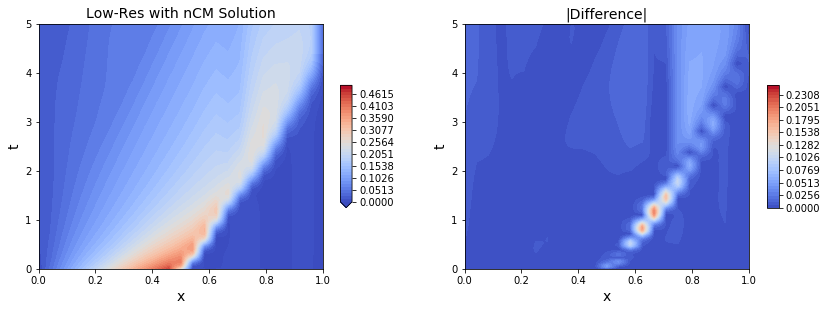

In [14]:
plot_obj.plot(pred_y)

### Print the network architecture

In [15]:
func_main.summary()

Model: "dde_func_main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  16        
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  65        
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80        
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  80        
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  80        
_________________________________________________________________
conv1d_transpose (Conv1DTran multiple                  48        
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr multiple                

### Compute errors

In [16]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*0.02
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [17]:
truth = tf.concat([true_u_low_res, val_true_u_low_res], axis=0)

err_obj = compute_error(truth)

In [18]:
np.round(err_obj.l2_error(pred_y), 3)

array([0.104], dtype=float32)

In [19]:
np.round(err_obj.RMSE(pred_y), 3)

0.045